# Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition. 

For many incumbent operators, retaining high profitable customers is the number one business goal. 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

# Business Objective

The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months.

# Solution

**Note:**

There are a few parts of this Notebook which takes extremely long time to run.

- Hyperparameter tuning in RF ~ 3hrs
- Hyperparameter tuning in XGB ~ 0.5hrs
- Hyperparameter tuning in Logistic Reg ~ 15mins
- Imputing Missing values ~ 3hrs

### Importing the required libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',240)
pd.set_option('display.max_rows',240)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer #for imputation

# others
import os
from math import log

# hide warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\akhilshu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\akhilshu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\akhilshu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The s

## Data Processing

### Importing and Understanding the data

In [2]:
df = pd.read_csv("telecom_churn_data.csv")
df.head(5)

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

Data Dictionary for Reference

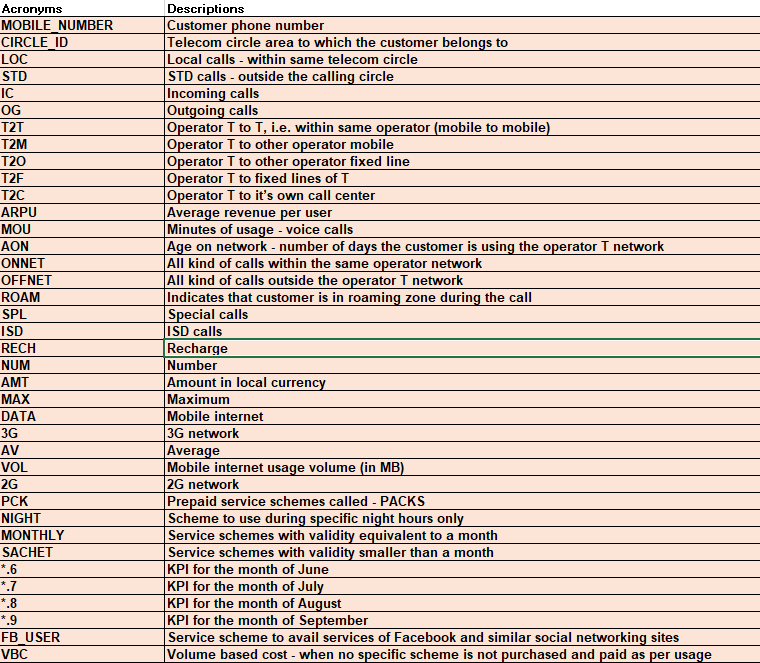

In [3]:
print('Shape of the dataset: ',df.shape)
# There are 999999 rows and 226 columns

Shape of the dataset:  (99999, 226)


### Number of Unique Values in the features

In [4]:
# Function to calculate number of unique values in each feature.
def uniq_in_var(df):
    for i in df.columns:
        print(str(i) + ' : ' + str(df[i].nunique()))
        
print('Number of unique values in different features is/are listed below:\n')
uniq_in_var(df)

Number of unique values in different features is/are listed below:

mobile_number : 99999
circle_id : 1
loc_og_t2o_mou : 1
std_og_t2o_mou : 1
loc_ic_t2o_mou : 1
last_date_of_month_6 : 1
last_date_of_month_7 : 1
last_date_of_month_8 : 1
last_date_of_month_9 : 1
arpu_6 : 85681
arpu_7 : 85308
arpu_8 : 83615
arpu_9 : 79937
onnet_mou_6 : 24313
onnet_mou_7 : 24336
onnet_mou_8 : 24089
onnet_mou_9 : 23565
offnet_mou_6 : 31140
offnet_mou_7 : 31023
offnet_mou_8 : 30908
offnet_mou_9 : 30077
roam_ic_mou_6 : 6512
roam_ic_mou_7 : 5230
roam_ic_mou_8 : 5315
roam_ic_mou_9 : 4827
roam_og_mou_6 : 8038
roam_og_mou_7 : 6639
roam_og_mou_8 : 6504
roam_og_mou_9 : 5882
loc_og_t2t_mou_6 : 13539
loc_og_t2t_mou_7 : 13411
loc_og_t2t_mou_8 : 13336
loc_og_t2t_mou_9 : 12949
loc_og_t2m_mou_6 : 20905
loc_og_t2m_mou_7 : 20637
loc_og_t2m_mou_8 : 20544
loc_og_t2m_mou_9 : 20141
loc_og_t2f_mou_6 : 3860
loc_og_t2f_mou_7 : 3863
loc_og_t2f_mou_8 : 3807
loc_og_t2f_mou_9 : 3758
loc_og_t2c_mou_6 : 2235
loc_og_t2c_mou_7 : 2426
loc

Note that the data does not contain any information about customers using T2O channel - i.e., Operator T to Other Operator (Fixed Line). 

Lets drop these columns, and others too which contain just one unique value throughout

In [5]:
# The features having just 1 unique value are not needed and can be dropped straight away
to_drop = [i for i in df.columns if (df[i].nunique() == 1)]
df = df.drop(to_drop, axis = 1)

# also we wont need `mobile_number` fature in our analysis. Hence drop

df = df.drop('mobile_number', axis = 1)

In [6]:
df.shape
# We are left with 209 features now. 16 features dropped, as they provided no information.

(99999, 209)

### Highly Valued Customers
<br>

**As per the problem statement we only need to predict churn for the high-value customers.**


***Definition of Highly Valued Customers*** - 

Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [7]:
# Total recharge amount for a month is defined as: total_rech_amt + av_rech_amt_data * total_rech_data

# filling the missing values as 0
df['av_rech_amt_data_6'] = df['av_rech_amt_data_6'].fillna(0)
df['av_rech_amt_data_7'] = df['av_rech_amt_data_7'].fillna(0)

df['total_rech_data_6'] = df['total_rech_data_6'].fillna(0)
df['total_rech_data_7'] = df['total_rech_data_7'].fillna(0)

# calculating the average values for the month of 6 and 7 (good phase)
df['av_amt_6_7'] = ((df.total_rech_amt_6 + (df.total_rech_data_6 * df.av_rech_amt_data_6))+ (df.total_rech_amt_7 + (df.total_rech_data_7 * df.av_rech_amt_data_7)))/2

print("Recharge amount for the 70th percentile:" + str(df.av_amt_6_7.quantile(0.7)))

# As per the question the HVC are those who have recharged with an amount >= to X, 
# where X is the 70th percentile of the average recharge amount in the first two months (the 
# good phase). This gives us 30K records for high value customers.

df_hvc = df.loc[df.av_amt_6_7 >= df.av_amt_6_7.quantile(0.7), :]
df_hvc.shape

Recharge amount for the 70th percentile:478.0


(30001, 210)

In [8]:
df_hvc = df_hvc.drop(['av_amt_6_7'], axis = 1) ## These columns are no longer needed
df_hvc.shape

(30001, 209)

### Missing value analysis

In [9]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : 'per_tot_val'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        'per_tot_val', ascending=False).round(1)
        
        # Print some summary information
        print ("Selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [10]:
# getting the missing values data

missing_values = missing_values_table(df_hvc)
missing_values.head(200)

Selected dataframe has 209 columns.
There are 148 columns that have missing values.


,Missing Values,per_tot_val
fb_user_9,14781,49.3
arpu_3g_9,14781,49.3
date_of_last_rech_data_9,14781,49.3
total_rech_data_9,14781,49.3
night_pck_user_9,14781,49.3
max_rech_data_9,14781,49.3
count_rech_2g_9,14781,49.3
arpu_2g_9,14781,49.3
count_rech_3g_9,14781,49.3
av_rech_amt_data_9,14781,49.3


In [11]:
# Note we will not be treating the _9 month columns for missing values as we will be dropping 
# them later anyways:

catergory_cols =  ['night_pck_user_6',
                     'night_pck_user_7',
                     'night_pck_user_8',
                     'fb_user_6',
                     'fb_user_7',
                     'fb_user_8'
                    ]

df_hvc[catergory_cols] = df_hvc[catergory_cols].apply(lambda x: x.fillna(-1))

In [12]:
# Recharge columns of 6,7,8 month which have missing values we can replace with 0 as missing 
# means they have not recharged in that month

missing_val_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
        'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8','count_rech_2g_8','count_rech_3g_8','count_rech_2g_6','count_rech_3g_6','count_rech_2g_7','count_rech_3g_7']

for colname in missing_val_cols:    
    df_hvc[colname] = df_hvc[colname].fillna(0)

In [13]:
# Derived Metrics - `Days since last Recharge`, `Days since last Data Recharge`

# for date of last recharge we will use only the 8th month data, i.e information of the month 
# before the churn and drop the date column of other months.

# The assumption here is that if they are recharging in the 8th month too then perhaps they plan 
# on staying, on similar line the recharge data of 6th and 7th month is not that much needed as 
# they have anyways stayed on till the 8th month


df_hvc = df_hvc.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_data_6',
                      'date_of_last_rech_data_7'], axis = 1)


# for the date_of_last_rech_8 and date_of_last_rech_data_8 columns we will convert these to dates are replace the missing values there 
# with an arbitrary higher value like 45 to signify that these accounts did not recharge in the 30 days of 8th month

df_hvc['date_of_last_rech_8'] = pd.to_datetime(df_hvc['date_of_last_rech_8'])
df_hvc['days_since_last_rech_8'] = pd.to_datetime("8/31/2014") - df_hvc['date_of_last_rech_8']
df_hvc['days_since_last_rech_8'] = df_hvc['days_since_last_rech_8']/np.timedelta64(1,'D')
df_hvc['days_since_last_rech_8'] = df_hvc['days_since_last_rech_8'].fillna(45)


df_hvc['date_of_last_rech_data_8'] = pd.to_datetime(df_hvc['date_of_last_rech_data_8'])
df_hvc['days_since_last_rech_data_8'] = pd.to_datetime("8/31/2014") - df_hvc['date_of_last_rech_data_8']
df_hvc['days_since_last_rech_data_8'] = df_hvc['days_since_last_rech_data_8']/np.timedelta64(1,'D')
df_hvc['days_since_last_rech_data_8'] = df_hvc['days_since_last_rech_data_8'].fillna(45)

df_hvc = df_hvc.drop(['date_of_last_rech_8','date_of_last_rech_data_8','date_of_last_rech_data_9'], axis = 1)
df_hvc.shape

(30001, 204)

### Tagging Churners
<br>
Next we will tag the churned customers (churn=1, else 0) based on the 9th month as follows: 

Those who have **not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase**. The attributes to be used to tag churners are:

- total_ic_mou_9
- total_og_mou_9
- vol_2g_mb_9
- vol_3g_mb_9


After tagging churners we will remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [14]:
df_hvc['Churn'] = df_hvc.apply(lambda x: 1 if((x['total_ic_mou_9']+x['total_og_mou_9']==0)and(x['vol_2g_mb_9']+x['vol_3g_mb_9']==0)) else 0, axis=1)

# Removing the 9 month data, as we will be predicting our churn for that month

df_hvc=df_hvc.drop(df_hvc.filter(like='_9',axis=1).columns,axis=1)

df_hvc.shape

(30001, 155)

### Imputation of continous variables with missing data

In [15]:
# we will be dropping a few columns, these columns have about 50% missing values. In the initial 
# dataset(before filtering high value customers) 
# these had 70% missing values,we did not drop them there, but we will drop them now before 
# going for iterative imputation

df_hvc = df_hvc.drop(['arpu_2g_8', 'arpu_2g_7', 'arpu_2g_6','arpu_3g_8', 'arpu_3g_7', 'arpu_3g_6'], axis = 1)

In [16]:
# getting the missing values data

missing_values = missing_values_table(df_hvc)
missing_values.head(200)

Selected dataframe has 149 columns.
There are 81 columns that have missing values.


,Missing Values,per_tot_val
ic_others_8,1174,3.9
loc_og_t2m_mou_8,1174,3.9
std_og_mou_8,1174,3.9
spl_og_mou_8,1174,3.9
std_og_t2f_mou_8,1174,3.9
og_others_8,1174,3.9
std_og_t2m_mou_8,1174,3.9
loc_ic_t2t_mou_8,1174,3.9
std_og_t2t_mou_8,1174,3.9
loc_ic_t2m_mou_8,1174,3.9


In [17]:
# Running the Iterative imputer of Sklearn

df_hvc_imputed = IterativeImputer(max_iter=100,verbose=1,random_state=100).fit_transform(df_hvc.values)

# Turning into df again
df_hvc_imputed = pd.DataFrame(data=df_hvc_imputed, columns=df_hvc.columns, index=df_hvc.index)

[IterativeImputer] Completing matrix with shape (30001, 149)
[IterativeImputer] Change: 4263.693822353078, scaled tolerance: 45.735400000000006 
[IterativeImputer] Change: 2414.345106108713, scaled tolerance: 45.735400000000006 
[IterativeImputer] Change: 471.59227105198306, scaled tolerance: 45.735400000000006 
[IterativeImputer] Change: 181.87307878045672, scaled tolerance: 45.735400000000006 
[IterativeImputer] Change: 167.9926119649669, scaled tolerance: 45.735400000000006 
[IterativeImputer] Change: 162.00511352191577, scaled tolerance: 45.735400000000006 
[IterativeImputer] Change: 155.20615215157662, scaled tolerance: 45.735400000000006 
[IterativeImputer] Change: 148.12874092116104, scaled tolerance: 45.735400000000006 
[IterativeImputer] Change: 141.1597444670814, scaled tolerance: 45.735400000000006 
[IterativeImputer] Change: 134.48559568019255, scaled tolerance: 45.735400000000006 
[IterativeImputer] Change: 128.10764869627124, scaled tolerance: 45.735400000000006 
[Iterati

In [18]:
df_hvc_imputed.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,days_since_last_rech_8,days_since_last_rech_data_8,Churn
0,197.385,214.816,213.803,-91.185316,-147.296556,0.00,224.858598,291.036732,0.00,48.454164,30.775225,0.00,100.399862,67.893782,0.00,-192.617442,-236.499328,0.00,166.251986,165.988416,0.00,6.475444,6.548507,0.00,3.027039,-1.641531,0.00,-19.959108,-63.924856,0.00,60.589122,64.592084,0.00,182.715291,191.363702,0.00,1.900115,1.954369,0.00,245.188066,257.931861,0.00,-231.703888,-201.304059,0.00,5.920664,7.233621,0.00,0.666482,0.073577,0.0,0.00,0.00,0.00,-78.817064,-91.16434,0.16,153.186263,154.390556,4.13,15.572442,16.325285,1.15,89.893488,79.527045,5.44,-39.955848,-40.43086,0.00,29.735191,31.385308,0.00,2.744852,2.846726,0.00,-7.489931,-6.210145,0.00,0.00,0.00,5.44,-90.895378,-83.372146,0.0,8.058512,8.737484,0.00,1.172602,1.526915,0.00,4.0,3.0,2.0,362.0,252.0,252.0,252.0,252.0,252.0,252.0,252.0,252.0,1.0,1.0,1.0,252.0,252.0,252.0,0.0,0.0,0.0,1.0,1.0,1.0,252.0,252.0,252.0,30.13,1.32,5.75,83.57,150.76,109.61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,968.0,30.40,0.00,101.20,3.58,23.0,23.0,1.0
7,1069.180,1349.850,3171.480,57.840000,54.680000,52.29,453.430000,567.160000,325.91,16.230000,33.490000,31.64,23.740000,12.590000,38.06,51.390000,31.380000,40.28,308.630000,447.380000,162.28,62.130000,55.140000,53.23,0.000000,0.000000,0.00,422.160000,533.910000,255.79,4.300000,23.290000,12.01,49.890000,31.760000,49.14,6.660000,20.080000,16.68,60.860000,75.140000,77.84,0.000000,0.180000,10.01,4.500000,0.000000,6.50,0.000000,0.000000,0.0,487.53,609.24,350.16,58.140000,32.26000,27.31,217.560000,221.490000,121.19,152.160000,101.460000,39.53,427.880000,355.230000,188.04,36.890000,11.83000,30.39,91.440000,126.990000,141.33,52.190000,34.240000,22.21,180.540000,173.080000,193.94,626.46,558.04,428.74,0.210000,0.000000,0.0,2.060000,14.530000,31.59,15.740000,15.190000,15.14,5.0,5.0,7.

In [19]:
# Observe some of the minutes_per_usage (mou) features have been filled with negative values,
# this isn't correct as mou cannot be negative

# lets find out how many columns are there which have been imputed with negative values.

col_neg_val = []
for col in df_hvc_imputed.columns:
    if (any(df_hvc_imputed[col] < 0)):
        col_neg_val.append(str(col))
        
print(len(col_neg_val))
print(col_neg_val)

43
['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']


In [20]:
# lets copy the mou features from above list and store them in col_make_pos. 
# We will replace the negative values in these columns to their respective medians.

col_make_pos = ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_7', 'offnet_mou_8', 
                'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_7', 'roam_og_mou_8', 
                'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2c_mou_6', 
                'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 
                'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 
                'loc_ic_t2t_mou_8', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 
                'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 
                'spl_ic_mou_8']

for col in col_make_pos:
    df_hvc_imputed[col][df_hvc_imputed[col] < 0] = df_hvc_imputed[col].median()

In [21]:
df_hvc = df_hvc_imputed.copy() #copying in the original data frame

In [22]:
# All missing values have been taken care of:

missing_values = missing_values_table(df_hvc)
missing_values.head(200)

Selected dataframe has 149 columns.
There are 0 columns that have missing values.


,Missing Values,per_tot_val


### Checking for class imbalance

Churn
0.0    27560
1.0     2441
dtype: int64


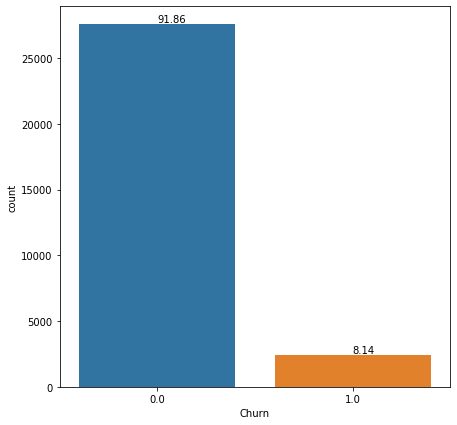

In [23]:
# Count classes and plot
print(df_hvc.groupby('Churn').size())

plt.figure(figsize=(7,7))
sns.countplot(x="Churn", data=df_hvc)
nochurn_percent = str(round(100* df_hvc.groupby('Churn').size() / df_hvc.shape[0], 2)[0])
churn_percent = str(round(100* df_hvc.groupby('Churn').size() / df_hvc.shape[0], 2)[1])
plt.text(0, 27700, nochurn_percent)
plt.text(1, 2600, churn_percent)
plt.show()

# As can be seen from the below plot there is a significant class imbalance problem in the data,
# as the Churn rate is pretty low at 8%.
# This is expected in problems of this catageory, we need to look out for this while training our model

### Data Visualization & Feature Engineering

Text(0.5, 1.0, 'Age on Network for Churned customers')

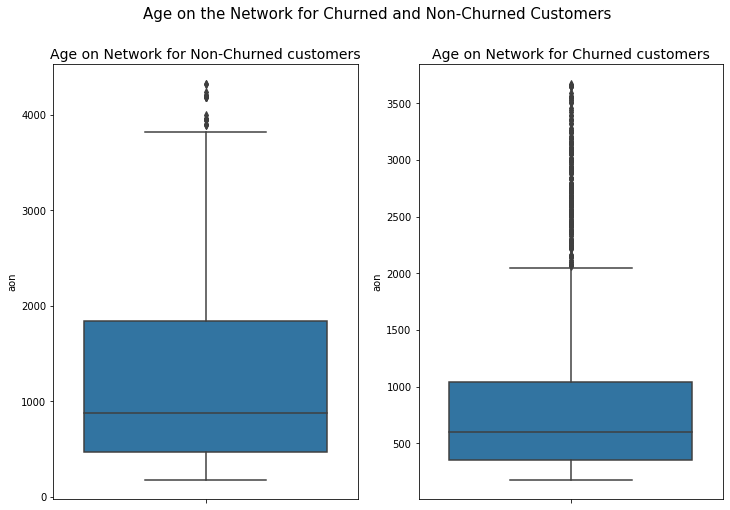

In [24]:
# lets see how the Age on Network relationship with Churn

fig = plt.figure(figsize=(12,8))
plt.suptitle('Age on the Network for Churned and Non-Churned Customers', fontsize = 15)

plt.subplot(1,2,1)
sns.boxplot(y = df_hvc[df_hvc.Churn == 0].aon)
plt.title('Age on Network for Non-Churned customers', fontsize = 14)

plt.subplot(1,2,2)
sns.boxplot(y = df_hvc[df_hvc.Churn == 1].aon)
plt.title('Age on Network for Churned customers', fontsize = 14)

#fig.tight_layout(pad = 3.0)

On comparing the two plots above, we notice that the Non-Churn customers are usually the ones who have been on the network for a long time. Whereas the Customers that churn out are not so old on the network.

`The Network is facing difficulty in retaining the new customers (who are not so old on the network).`

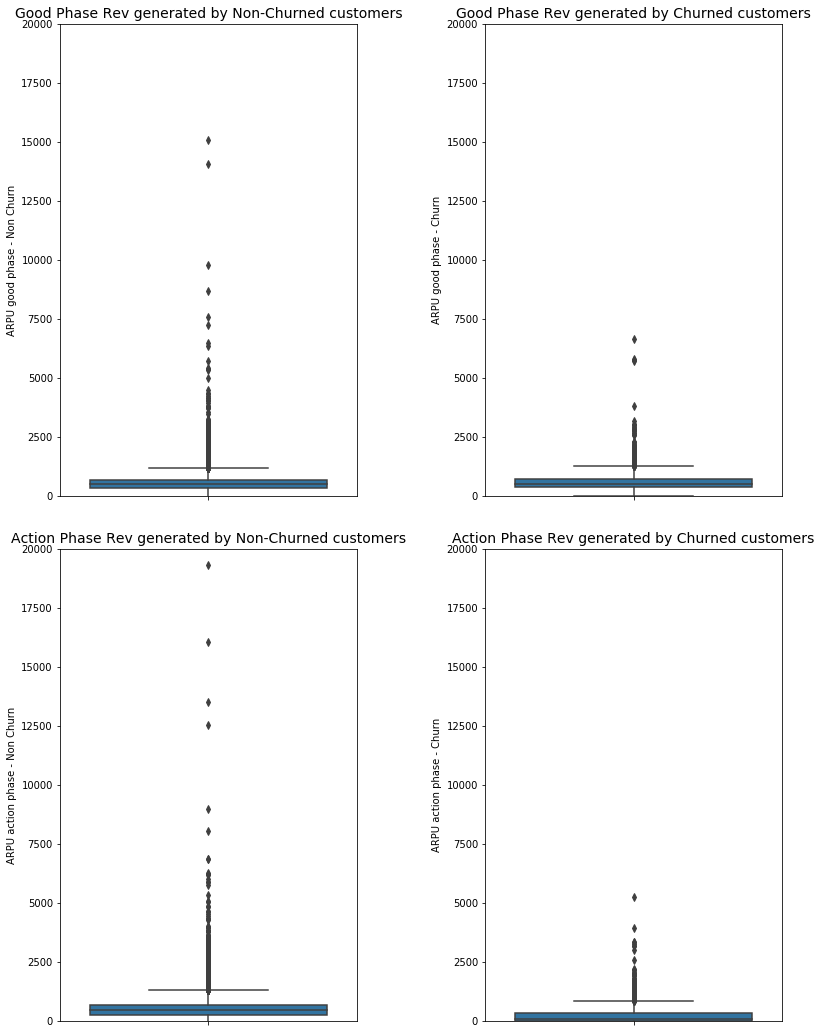

In [25]:
# Lets see the Average Revenue Per User relationship vs Churn

df_hvc['arpu_good'] = (df_hvc['arpu_6'] + df_hvc['arpu_7'])/2
# lets see how the Age on Network relationship with Churn
fig = plt.figure(figsize=(12,15))
#plt.suptitle('Avg Rev generated for Churned and Non-Churned Customers', fontsize = 15)

# In good Phase
plt.subplot(2,2,1)
sns.boxplot(y = df_hvc[df_hvc.Churn == 0].arpu_good).set(ylim=(0,20000))
plt.title('Good Phase Rev generated by Non-Churned customers', fontsize = 14)
plt.ylabel('ARPU good phase - Non Churn')

plt.subplot(2,2,2)
sns.boxplot(y = df_hvc[df_hvc.Churn == 1].arpu_good).set(ylim=(0,20000))
plt.title('Good Phase Rev generated by Churned customers', fontsize = 14)
plt.ylabel('ARPU good phase - Churn')

# In action Phase
plt.subplot(2,2,3)
sns.boxplot(y = df_hvc[df_hvc.Churn == 0].arpu_8).set(ylim=(0,20000))
plt.title('Action Phase Rev generated by Non-Churned customers', fontsize = 14)
plt.ylabel('ARPU action phase - Non Churn')

plt.subplot(2,2,4)
sns.boxplot(y = df_hvc[df_hvc.Churn == 1].arpu_8).set(ylim=(0,20000))
plt.title('Action Phase Rev generated by Churned customers', fontsize = 14)
plt.ylabel('ARPU action phase - Churn')

fig.tight_layout(pad = 3.0)

df_hvc = df_hvc.drop('arpu_good', axis = 1)   # dropping average columns

***Compare the plot1 and plot2:***
- It shows the ARPU generated in the `Good Phase` by Churn and Non Churn Customers
- Observe that the Revenue generated by the Customers in Good phase was similar for both Churn and Non- Churn customers.
<br>

***Compare the plot3 and plot4:***
- It diplays the ARPU generated in the `Action Phase` by Churn and Non-Churn Customers 
- Observe that the Revenue generated by the Non-Churn Customers in this action phase was almost similar to revenue generated by them in the good phase.
- Whereas the Revenue generated by the Churn Customers in this action phase has reduced substantially compared with the good phase.
<br><br>
These observation are inline with our expectations, as the Churn customers are expected to generate less revenue (use less services) following which they'd churn.

count    27560.000000
mean       103.218203
std        360.572150
min          0.000000
25%          0.000000
50%          0.000000
75%         41.422500
max      10815.690000
Name: Roam_min, dtype: float64

 count     2441.000000
mean       325.409934
std        702.189059
min          0.000000
25%         15.050000
50%        175.950000
75%        302.541455
max      10749.750000
Name: Roam_min, dtype: float64


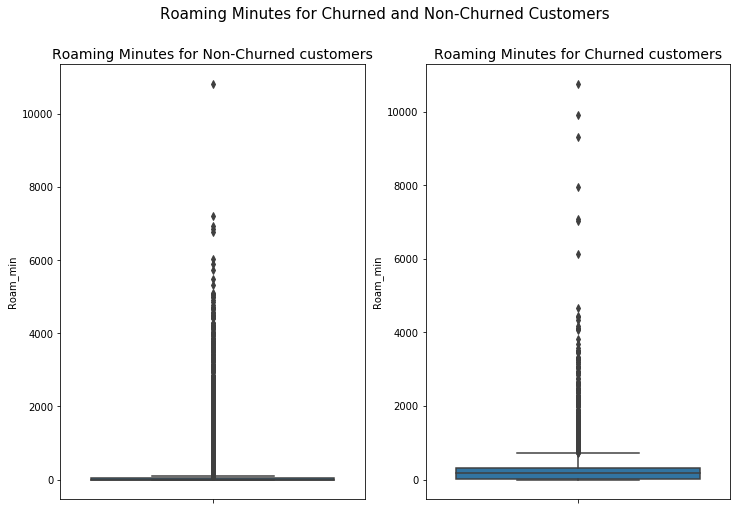

In [26]:
## Roaming - To check how the telecom service is when the customer is away from the home network.
##           Services such as roaming require transfer of connection to different cell networks.
##           Disruptions in Call Roaming service may indicate weak or non robust cell network, 
##           forcing customers to churn.

# Adding all roaming minutes (incoming + outgoing) in Roam_min
df_hvc['Roam_min'] = df_hvc['roam_ic_mou_6'] + df_hvc['roam_ic_mou_7'] + df_hvc['roam_ic_mou_8'] +df_hvc['roam_og_mou_6'] + df_hvc['roam_og_mou_7'] + df_hvc['roam_og_mou_8']


fig = plt.figure(figsize=(12,8))
plt.suptitle('Roaming Minutes for Churned and Non-Churned Customers', fontsize = 15)

plt.subplot(1,2,1)
sns.boxplot(y = df_hvc[df_hvc.Churn == 0].Roam_min)
plt.title('Roaming Minutes for Non-Churned customers', fontsize = 14)

plt.subplot(1,2,2)
sns.boxplot(y = df_hvc[df_hvc.Churn == 1].Roam_min)
plt.title('Roaming Minutes for Churned customers', fontsize = 14)

#fig.tight_layout(pad = 3.0)

# Let us also print the statistical distribution of the Roaming minutes across Churn/Non-Churn
print(df_hvc[df_hvc.Churn == 0].Roam_min.describe())
print('\n',df_hvc[df_hvc.Churn == 1].Roam_min.describe())


df_hvc = df_hvc.drop('Roam_min', axis = 1)   # dropping Roam_min columns

It can be clearly seen that the people who spend more roaming minutes on call are more likely to churn. This indicates that the network for mobility calls, call cell handovers are possibly not performing upto the mark.

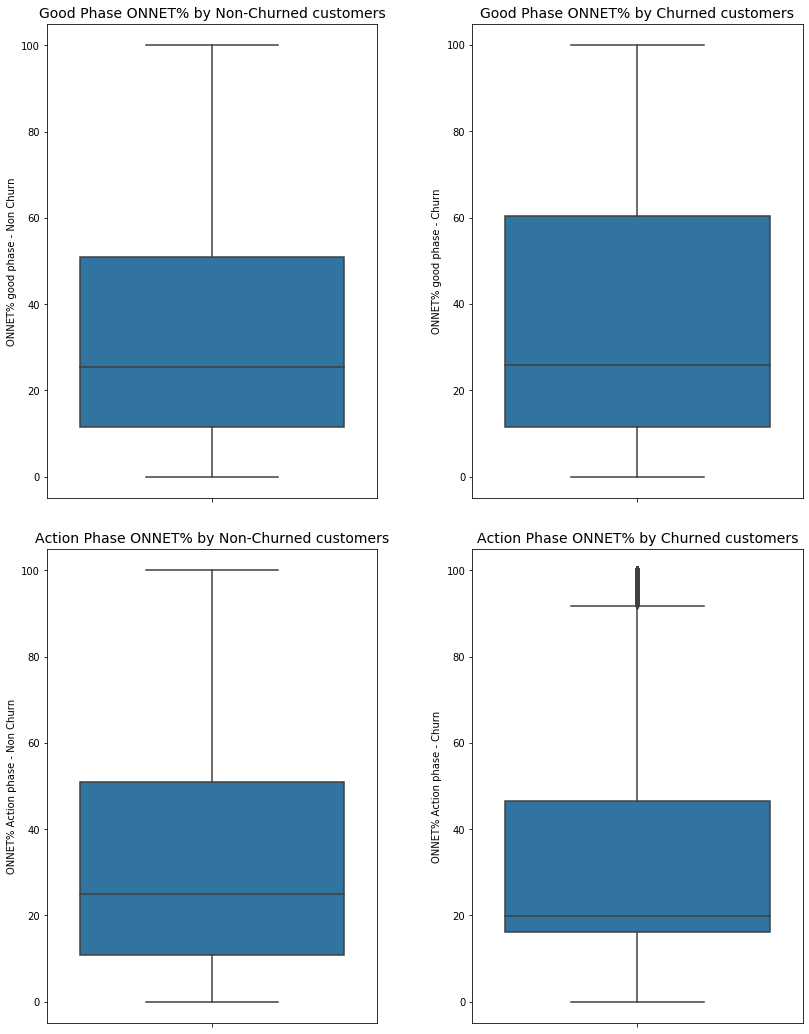

In [27]:
## ONNET vs OFFNET calls, assumption is that a person making calls to other network more often might churn as the all his contacts are in a different network

# To do this we will take % of ONNNET/Total i.e, (ONNET)/(ONNET + OFFNET)

# onnet - good phase
df_hvc['onnet_per_good'] = 100*(df_hvc['onnet_mou_6'] + df_hvc['onnet_mou_7'])/(df_hvc['onnet_mou_6'] + df_hvc['onnet_mou_7'] + df_hvc['offnet_mou_6'] + df_hvc['offnet_mou_7'])
# onnet - action phase
df_hvc['onnet_per_action'] = 100*(df_hvc['onnet_mou_8'])/(df_hvc['onnet_mou_8'] + df_hvc['offnet_mou_8'])


fig = plt.figure(figsize=(12,15))


# In good Phase
plt.subplot(2,2,1)
sns.boxplot(y = df_hvc[df_hvc.Churn == 0].onnet_per_good)
plt.title('Good Phase ONNET% by Non-Churned customers', fontsize = 14)
plt.ylabel('ONNET% good phase - Non Churn')

plt.subplot(2,2,2)
sns.boxplot(y = df_hvc[df_hvc.Churn == 1].onnet_per_good)
plt.title('Good Phase ONNET% by Churned customers', fontsize = 14)
plt.ylabel('ONNET% good phase - Churn')

# In action Phase
plt.subplot(2,2,3)
sns.boxplot(y = df_hvc[df_hvc.Churn == 0].onnet_per_action)
plt.title('Action Phase ONNET% by Non-Churned customers', fontsize = 14)
plt.ylabel('ONNET% Action phase - Non Churn')

plt.subplot(2,2,4)
sns.boxplot(y = df_hvc[df_hvc.Churn == 1].onnet_per_action)
plt.title('Action Phase ONNET% by Churned customers', fontsize = 14)
plt.ylabel('ONNET% Action phase - Churn')

fig.tight_layout(pad = 3.0)


dropcols = ['onnet_per_good','onnet_per_action']

df_hvc = df_hvc.drop(dropcols, axis = 1)   # dropping columns

It looks like churned customers made slightly less number of calls in the action phase within the same network, which is obvious, as they are about to churn. No significant insight

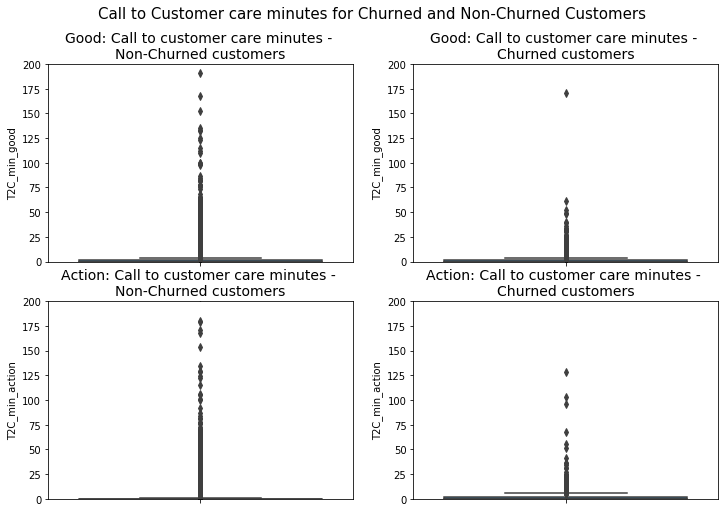

In [28]:
## Minutes of call to customer care, hinting dissatisfaction with the current service/ complaints 
## etc. 

# Lets plot `T2C_min`(No. of minutes spent on Local calls to Customer care) vs Churn/Non-Churn.

#T2C - good phase
df_hvc['T2C_min_good'] = (df_hvc['loc_og_t2c_mou_6'] + df_hvc['loc_og_t2c_mou_7'])/2
#T2C - action phase
df_hvc['T2C_min_action'] = df_hvc['loc_og_t2c_mou_8']

fig = plt.figure(figsize=(12,8))
plt.suptitle('Call to Customer care minutes for Churned and Non-Churned Customers', fontsize = 15)

plt.subplot(2,2,1)
sns.boxplot(y = df_hvc[df_hvc.Churn == 0].T2C_min_good).set(ylim=(0,200))
plt.title('Good: Call to customer care minutes - \nNon-Churned customers', fontsize = 14)

plt.subplot(2,2,2)
sns.boxplot(y = df_hvc[df_hvc.Churn == 1].T2C_min_good).set(ylim=(0,200))
plt.title('Good: Call to customer care minutes - \nChurned customers', fontsize = 14)

plt.subplot(2,2,3)
sns.boxplot(y = df_hvc[df_hvc.Churn == 0].T2C_min_action).set(ylim=(0,200))
plt.title('Action: Call to customer care minutes - \nNon-Churned customers', fontsize = 14)

plt.subplot(2,2,4)
sns.boxplot(y = df_hvc[df_hvc.Churn == 1].T2C_min_action).set(ylim=(0,200))
plt.title('Action: Call to customer care minutes - \nChurned customers', fontsize = 14)

#fig.tight_layout(pad = 3.0)

# Let us also print the statistical distribution of the T2C minutes across Churn/Non-Churn
# print(df_hvc[df_hvc.Churn == 0].T2C_min_good.describe())
# print('\n',df_hvc[df_hvc.Churn == 1].T2C_min.describe())


df_hvc = df_hvc.drop(['T2C_min_good', 'T2C_min_action'], axis = 1)

From observation, we find that the minutes of Call to customer care has almost remained in both the phases. This is counter intuitive as one would expect more customer care call would in general indicate service dissatisfaction.

It rather could be possible that the Customer service offered by the T Operator is not good/ not as effective in resolving customer's grievances. This might be a contributing factor to churn.

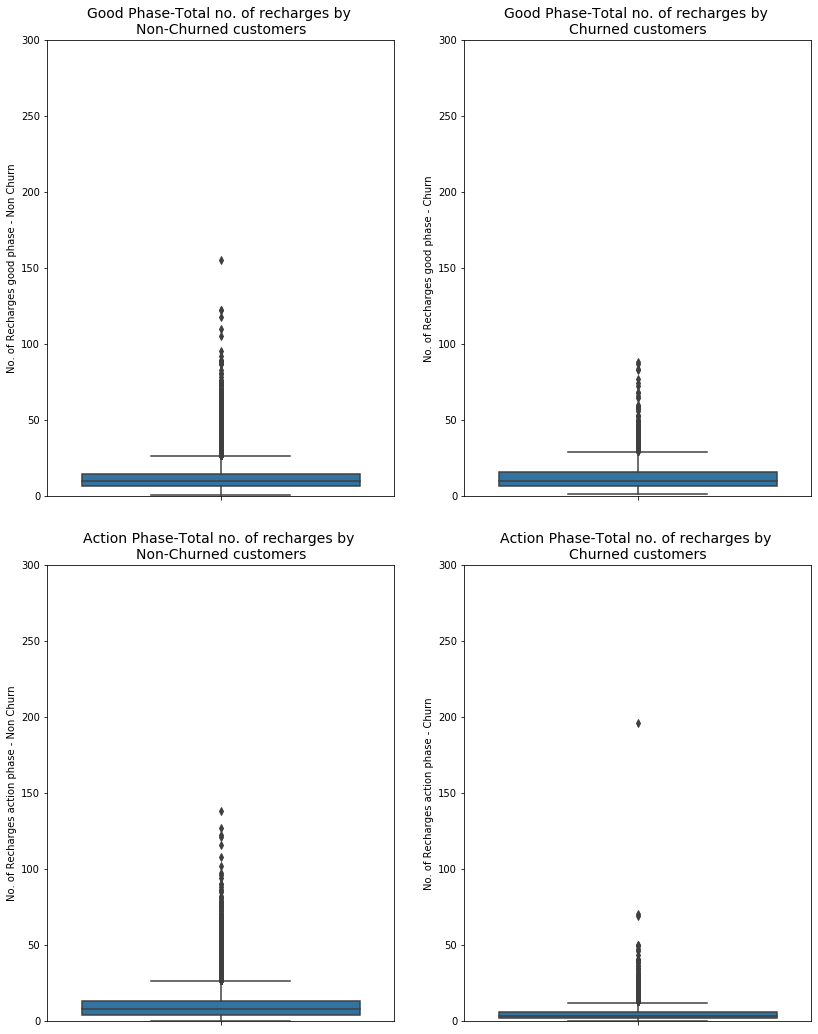

In [29]:
# Lets see the Total num. of recharges in good/action phases vs Churn

df_hvc['total_rech_num_good'] = (df_hvc['total_rech_num_6'] + df_hvc['total_rech_num_7'])/2


fig = plt.figure(figsize=(12,15))
#plt.suptitle('Total num of recharges for Churned and Non-Churned Customers', fontsize = 15)

# In good Phase
plt.subplot(2,2,1)
sns.boxplot(y = df_hvc[df_hvc.Churn == 0].total_rech_num_good).set(ylim=(0,300))
plt.title('Good Phase-Total no. of recharges by \nNon-Churned customers', fontsize = 14)
plt.ylabel('No. of Recharges good phase - Non Churn')

plt.subplot(2,2,2)
sns.boxplot(y = df_hvc[df_hvc.Churn == 1].total_rech_num_good).set(ylim=(0,300))
plt.title('Good Phase-Total no. of recharges by \nChurned customers', fontsize = 14)
plt.ylabel('No. of Recharges good phase - Churn')

# In action Phase
plt.subplot(2,2,3)
sns.boxplot(y = df_hvc[df_hvc.Churn == 0].total_rech_num_8).set(ylim=(0,300))
plt.title('Action Phase-Total no. of recharges by \nNon-Churned customers', fontsize = 14)
plt.ylabel('No. of Recharges action phase - Non Churn')

plt.subplot(2,2,4)
sns.boxplot(y = df_hvc[df_hvc.Churn == 1].total_rech_num_8).set(ylim=(0,300))
plt.title('Action Phase-Total no. of recharges by \nChurned customers', fontsize = 14)
plt.ylabel('No. of Recharges action phase - Churn')

fig.tight_layout(pad = 3.0)

df_hvc = df_hvc.drop('total_rech_num_good', axis = 1)

***Compare the plot1 and plot2:***
- It shows the Total no. of Recharges in the `Good Phase` by both Churn and Non Churn Customers
- Observe that the no. of recharges by the Customers in Good phase was similar for both Churn and Non- Churn customers.
<br>

***Compare the plot3 and plot4:***
- It diplays the Total no. of Recharges in the `Action Phase` by Churn and Non-Churn Customers 
- Observe that the no. of recharges by the Non-Churn Customers in this action phase was almost similar to that in good phase.
- Whereas the the no. of recharges by the Churn Customers in the action phase has decreased compared with the good phase.
<br><br>
This observation is quite intuitive, as num. of recharges are expected to go down for churn customers in action phase.

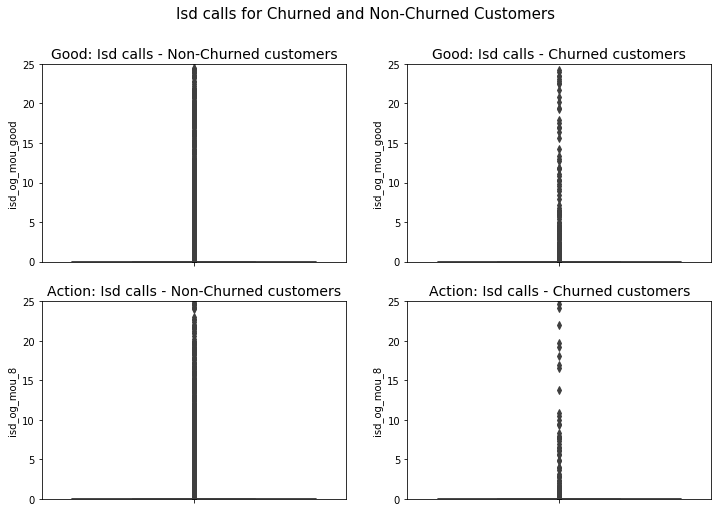

In [30]:
## Minutes of isd call - poor service on isd calls could be a reason for churning 
## etc. 

# Lets plot isd outgoing mou (No. of minutes spent on isd calls) for Churn/Non-Churn.

# isd outgoing mou - good phase
df_hvc['isd_og_mou_good'] = (df_hvc['isd_og_mou_6'] + df_hvc['isd_og_mou_7'])/2

fig = plt.figure(figsize=(12,8))
plt.suptitle('Isd calls for Churned and Non-Churned Customers', fontsize = 15)

plt.subplot(2,2,1)
sns.boxplot(y = df_hvc[df_hvc.Churn == 0].isd_og_mou_good).set(ylim=(0,25))
plt.title('Good: Isd calls - Non-Churned customers', fontsize = 14)

plt.subplot(2,2,2)
sns.boxplot(y = df_hvc[df_hvc.Churn == 1].isd_og_mou_good).set(ylim=(0,25))
plt.title('Good: Isd calls - Churned customers', fontsize = 14)

plt.subplot(2,2,3)
sns.boxplot(y = df_hvc[df_hvc.Churn == 0].isd_og_mou_8).set(ylim=(0,25))
plt.title('Action: Isd calls - Non-Churned customers', fontsize = 14)

plt.subplot(2,2,4)
sns.boxplot(y = df_hvc[df_hvc.Churn == 1].isd_og_mou_8).set(ylim=(0,25))
plt.title('Action: Isd calls - Churned customers', fontsize = 14)

df_hvc = df_hvc.drop(['isd_og_mou_good'], axis = 1)   # dropping isd_og_mou_good column

There are very less number of customers making ISD calls which is understood. No clear insights here.

### Seperating between good and action phase

We have 155 columns. Most of the features have distribution over 6th, 7th and 8th months. Since 6th and 7th month together comprise of the Good Phase, we can make new columns containing the average of 6th and 7th month features, and drop the individual 6h, 7th month features.
This will help reduce columns, as keeping 6th and 7th month data individually isn't needed.

We will call the new features (i.e. avg of 6th & 7th month features) as featurename***_avg_good***.<br>
We will also suffix and call the 8th month features as featurename***_action***.

In [31]:
# Lets average the 6th and 7th month feature and store the new feature names in list col_avg_good

col_avg_good = []
for i in range(0, len(df_hvc.columns) - 8, 3):
    col_avg_good.append((df_hvc.columns)[i].split('_6')[0] + '_avg_good')


In [32]:
# Lets store the features related to 6th and 7th month resp. in col_6th and col_7th

col_6th = []
col_7th = []

col_all = [i for i in df_hvc.columns]
for j, k in zip(range(0, len(col_all) - 8, 3), range(1, len(col_all) - 8, 3)):
    col_6th.append(col_all[j])
    col_7th.append(col_all[k])


In [33]:
# Lets create a new dataframe df_hvc_good, and store the avg good phase data in this

df_hvc_good = pd.DataFrame(columns = col_avg_good)
for x, y, z in zip(col_6th, col_7th, col_avg_good):
    df_hvc_good[z] = (df_hvc[x] + df_hvc[y])/2
    
df_hvc_good.head()

,arpu_avg_good,onnet_mou_avg_good,offnet_mou_avg_good,roam_ic_mou_avg_good,roam_og_mou_avg_good,loc_og_t2t_mou_avg_good,loc_og_t2m_mou_avg_good,loc_og_t2f_mou_avg_good,loc_og_t2c_mou_avg_good,loc_og_mou_avg_good,std_og_t2t_mou_avg_good,std_og_t2m_mou_avg_good,std_og_t2f_mou_avg_good,std_og_mou_avg_good,isd_og_mou_avg_good,spl_og_mou_avg_good,og_others_avg_good,total_og_mou_avg_good,loc_ic_t2t_mou_avg_good,loc_ic_t2m_mou_avg_good,loc_ic_t2f_mou_avg_good,loc_ic_mou_avg_good,std_ic_t2t_mou_avg_good,std_ic_t2m_mou_avg_good,std_ic_t2f_mou_avg_good,std_ic_mou_avg_good,total_ic_mou_avg_good,spl_ic_mou_avg_good,isd_ic_mou_avg_good,ic_others_avg_good,total_rech_num_avg_good,total_rech_amt_avg_good,max_rech_amt_avg_good,last_day_rch_amt_avg_good,total_rech_data_avg_good,max_rech_data_avg_good,count_rech_2g_avg_good,count_rech_3g_avg_good,av_rech_amt_data_avg_good,vol_2g_mb_avg_good,vol_3g_mb_avg_good,night_pck_user_avg_good,monthly_2g_avg_good,sachet_2g_avg_good,monthly_3g_avg_good,sachet_3g_avg_good,fb_user_avg_good
0,206.1005,83.695,257.947665,39.614695,84.146822,24.505,166.120201,6.511976,1.513519,126.210,62.590603,187.039496,1.927242,251.559963,0.000,6.577142,0.370029,0.000,25.430,153.788409,15.948863,84.710267,0.415,30.560249,2.795789,11.750,0.000,0.000,8.397998,1.349758,3.5,307.0,252.0,252.0,1.0,252.0,0.0,1.0,252.0,15.725,117.165,0.0,0.0,0.0,1.0,0.0,1.0
7,1209.5150,56.260,510.295000,24.860000,18.165000,41.385,378.005000,58.635000,0.000000,478.035,13.795000,40.825000,13.370000,68.000000,0.090,2.250000,0.000000,548.385,45.200,219.525000,126.810000,391.555000,24.360,109.215000,43.215000,176.810,592.250,0.105,8.295000,15.465000,5.0,1185.0,1185.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,-1.0,0.0,0.0,0.0,0.0,-1.0
8,435.4720,382.360,87.645000,0.000000,0.000000,257.360,75.770000,0.000000,0.000000,333.135,124.995000,11.865000,0.000000,136.870000,0.000,0.000000,0.000000,470.010,16.840,35.780000,0.000000,52.630000,0.290,13.255000,0.000000,13.545,66.175,0.000,0.000000,0.000000,20.0,519.0,122.0,25.0,1.0,77.0,1.0,0.0,88.5,178.000,375.475,-0.5,0.5,0.5,0.0,0.0,0.0
21,556.1030,117.260,827.305000,0.000000,0.000000,5.320,89.870000,0.375000,0.000000,95.565,111.935000,737.050000,0.000000,848.990000,0.000,0.000000,0.000000,944.565,6.335,96.430000,3.725000,106.505000,10.020,52.960000,0.000000,62.985,169.490,0.000,0.000000,0.000000,24.0,640.0,50.0,25.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,-1.0,0.0,0.0,0.0,0.0,-1.0
23,134.1235,49.810,87.385000,0.000000,0.000000,49.810,82.975000,0.000000,0.000000,132.795,0.000000,4.355000,0.000000,4.355000,0.005,0.050000,0.000000,137.210,40.875,104.635000,0.000000,145.520000,0.255,8.660000,0.000000,8.915,171.235,0.000,14.115000,2.675000,4.0,227.0,89.5,89.5,1.0,89.5,0.0,1.0,178.0,0.240,299.545,-0.5,0.0,0.0,1.0,0.0,0.0


In [34]:
# also lets drop the col_6th and col_7th from the original df_hvc dataset
df_hvc = df_hvc.drop(col_6th, axis = 1)
df_hvc = df_hvc.drop(col_7th, axis = 1)
df_hvc.shape

(30001, 55)

In [35]:
# in the original dataset df_hvc, lets suffix 8th month feature names `_action`

col_8th = []
for i in range(len(df_hvc.columns)):
    col_8th.append((list(df_hvc.columns))[i].replace('_8', '_action'))

# lets rename the column names in the df_hvc dataset
df_hvc.columns = col_8th
df_hvc

,arpu_action,onnet_mou_action,offnet_mou_action,roam_ic_mou_action,roam_og_mou_action,loc_og_t2t_mou_action,loc_og_t2m_mou_action,loc_og_t2f_mou_action,loc_og_t2c_mou_action,loc_og_mou_action,std_og_t2t_mou_action,std_og_t2m_mou_action,std_og_t2f_mou_action,std_og_mou_action,isd_og_mou_action,spl_og_mou_action,og_others_action,total_og_mou_action,loc_ic_t2t_mou_action,loc_ic_t2m_mou_action,loc_ic_t2f_mou_action,loc_ic_mou_action,std_ic_t2t_mou_action,std_ic_t2m_mou_action,std_ic_t2f_mou_action,std_ic_mou_action,total_ic_mou_action,spl_ic_mou_action,isd_ic_mou_action,ic_others_action,total_rech_num_action,total_rech_amt_action,max_rech_amt_action,last_day_rch_amt_action,total_rech_data_action,max_rech_data_action,count_rech_2g_action,count_rech_3g_action,av_rech_amt_data_action,vol_2g_mb_action,vol_3g_mb_action,night_pck_user_action,monthly_2g_action,sachet_2g_action,monthly_3g_action,sachet_3g_action,fb_user_action,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,days_since_last_rech_action,days_since_last_rech_data_action,Churn
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.16,4.13,1.15,5.44,0.00,0.00,0.00,0.00,5.44,0.0,0.00,0.00,2.0,252.0,252.0,252.0,1.0,252.0,0.0,1.0,252.0,5.75,109.61,0.0,0.0,0.0,1.0,0.0,1.0,968.0,30.40,0.00,101.20,3.58,23.0,23.0,1.0
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,12.01,49.14,16.68,77.84,10.01,6.50,0.0,350.16,27.31,121.19,39.53,188.04,30.39,141.33,22.21,193.94,428.74,0.0,31.59,15.14,7.0,3638.0,1580.0,779.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,-1.0,0.0,0.0,0.0,0.0,-1.0,802.0,57.74,19.38,18.74,0.00,5.0,45.0,1.0
8,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,63.04,22.58,75.69,0.00,98.28,0.00,10.23,0.0,171.56,0.31,15.48,0.00,15.79,0.10,0.65,0.00,0.75,16.54,0.0,0.00,0.00,14.0,120.0,30.0,10.0,3.0,23.0,3.0,0.0,69.0,0.03,11.94,0.0,0.0,3.0,0.0,0.0,1.0,315.0,21.03,910.65,122.16,0.00,1.0,8.0,0.0
21,637.760,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,129.74,61.79,876.99,0.00,938.79,0.00,0.00,0.0,1068.54,19.54,129.16,10.39,159.11,0.18,101.74,0.00,101.93,261.04,0.0,0.00,0.00,27.0,718.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,-1.0,0.0,0.0,0.0,0.0,-1.0,720.0,0.00,0.00,0.00,0.00,0.0,45.0,0.0
23,366.966,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,182.14,0.00,39.61,0.00,39.61,0.00,17.71,0.0,239.48,76.64,146.84,0.71,224.21,13.38,43.91,0.00,57.29,298.33,0.0,3.74,13.06,4.0,439.0,179.0,0.0,2.0,179.0,0.0,2.0,270.0,0.01,1009.92,0.0,0.0,0.0,1.0,1.0,1.0,604.0,40.45,51.86,0.00,0.00,7.0,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99981,393.474,103.24,61.44,0.00,0.00,89.23,55.59,5.76,0.00,150.59,14.01,0.00,0.00,14.01,0.00,0.08,0.0,164.69,303.61,58.54,40.41,402.58,17.36,0.00,0.00,17.36,420.46,0.0,0.00,0.51,3.0,512.0,252.0,130.0,1.0,252.0,0.0,1.0,252.0,112.07,1012.70,0.0,0.0,0.0,1.0,0.0,1.0,473.0,1100.43,619.59,668.05,0.33,4.0,8.0,0.0
99984,118.707,5.71,18.26,0.00,0.00,5.71,10.98,0.00,7.28,16.69,0.00,0.00,0.00,0.00,0.00,7.28,0.0,23.98,20.94,81.86,0.00,102.81,0.00,0.00,0.00,0.00,102.81,0.0,0.00,0.00,9.0,137.0,30.0,25.0,5.0,25.0,5.0,0.0,117.0,202.22,0.00,0.0,0.0,5.0,0.0,0.0,1.0,820.0,0.00,0.00,0.00,0.00,4.0,4.0,0.0
99986,564.334,775.41,595.44,0.00,0.00,718.56,493.48,13.01,9.15,1225.06,56.84,88.94,0.00,145.79,0.00,9.15,0.0,1380.01,148.21,450.01,37.61,635.84,0.00,23.71,0.45,24.16,660.01,0.0,0.00,0.00,3.0,25.0,25.0,0.0,1.0,25.0,1.0,0.0,25.0,6.47,926.78,0.0,0.0,1.0,0.0,0.0,1.0,2696.0,497.45,598.67,604.08,0.00,13.0,17.0,0.0
99988,402.080,2.46,248.33,0.00,0.00,2.46,128.01,0.00,0.01,130.48,0.00,120.29,0.00,120.29,0.00,0.01,0.0,250.79,1.50,1122.83,20.31,1144.64,2.03,86.11,0.71,88.86,1233.83,0.0,0.00,0.31,9.0,504.0,154.0,50.0,1.0,154.0,1.0,0.0,154.0,0.79,678.74,0.0,1.0,0.0,0.0,0.0,1.0,328.0,104.73,0.00,0.00,0.00,2.0,8.0,0.0


In [36]:
# Joing the Action and Good Phase data
df_hvc_final = df_hvc_good.join(df_hvc)
df_hvc_final

,arpu_avg_good,onnet_mou_avg_good,offnet_mou_avg_good,roam_ic_mou_avg_good,roam_og_mou_avg_good,loc_og_t2t_mou_avg_good,loc_og_t2m_mou_avg_good,loc_og_t2f_mou_avg_good,loc_og_t2c_mou_avg_good,loc_og_mou_avg_good,std_og_t2t_mou_avg_good,std_og_t2m_mou_avg_good,std_og_t2f_mou_avg_good,std_og_mou_avg_good,isd_og_mou_avg_good,spl_og_mou_avg_good,og_others_avg_good,total_og_mou_avg_good,loc_ic_t2t_mou_avg_good,loc_ic_t2m_mou_avg_good,loc_ic_t2f_mou_avg_good,loc_ic_mou_avg_good,std_ic_t2t_mou_avg_good,std_ic_t2m_mou_avg_good,std_ic_t2f_mou_avg_good,std_ic_mou_avg_good,total_ic_mou_avg_good,spl_ic_mou_avg_good,isd_ic_mou_avg_good,ic_others_avg_good,total_rech_num_avg_good,total_rech_amt_avg_good,max_rech_amt_avg_good,last_day_rch_amt_avg_good,total_rech_data_avg_good,max_rech_data_avg_good,count_rech_2g_avg_good,count_rech_3g_avg_good,av_rech_amt_data_avg_good,vol_2g_mb_avg_good,vol_3g_mb_avg_good,night_pck_user_avg_good,monthly_2g_avg_good,sachet_2g_avg_good,monthly_3g_avg_good,sachet_3g_avg_good,fb_user_avg_good,arpu_action,onnet_mou_action,offnet_mou_action,roam_ic_mou_action,roam_og_mou_action,loc_og_t2t_mou_action,loc_og_t2m_mou_action,loc_og_t2f_mou_action,loc_og_t2c_mou_action,loc_og_mou_action,std_og_t2t_mou_action,std_og_t2m_mou_action,std_og_t2f_mou_action,std_og_mou_action,isd_og_mou_action,spl_og_mou_action,og_others_action,total_og_mou_action,loc_ic_t2t_mou_action,loc_ic_t2m_mou_action,loc_ic_t2f_mou_action,loc_ic_mou_action,std_ic_t2t_mou_action,std_ic_t2m_mou_action,std_ic_t2f_mou_action,std_ic_mou_action,total_ic_mou_action,spl_ic_mou_action,isd_ic_mou_action,ic_others_action,total_rech_num_action,total_rech_amt_action,max_rech_amt_action,last_day_rch_amt_action,total_rech_data_action,max_rech_data_action,count_rech_2g_action,count_rech_3g_action,av_rech_amt_data_action,vol_2g_mb_action,vol_3g_mb_action,night_pck_user_action,monthly_2g_action,sachet_2g_action,monthly_3g_action,sachet_3g_action,fb_user_action,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,days_since_last_rech_action,days_since_last_rech_data_action,Churn
0,206.1005,83.695,257.947665,39.614695,84.146822,24.505,166.120201,6.511976,1.513519,126.210,62.590603,187.039496,1.927242,251.559963,0.000,6.577142,0.370029,0.000,25.430,153.788409,15.948863,84.710267,0.415,30.560249,2.795789,11.750,0.000,0.000,8.397998,1.349758,3.5,307.0,252.0,252.0,1.0,252.0,0.0,1.0,252.0,15.725,117.165,0.0,0.0,0.0,1.0,0.0,1.0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.16,4.13,1.15,5.44,0.00,0.00,0.00,0.00,5.44,0.0,0.00,0.00,2.0,252.0,252.0,252.0,1.0,252.0,0.0,1.0,252.0,5.75,109.61,0.0,0.0,0.0,1.0,0.0,1.0,968.0,30.40,0.00,101.20,3.58,23.0,23.0,1.0
7,1209.5150,56.260,510.295000,24.860000,18.165000,41.385,378.005000,58.635000,0.000000,478.035,13.795000,40.825000,13.370000,68.000000,0.090,2.250000,0.000000,548.385,45.200,219.525000,126.810000,391.555000,24.360,109.215000,43.215000,176.810,592.250,0.105,8.295000,15.465000,5.0,1185.0,1185.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,-1.0,0.0,0.0,0.0,0.0,-1.0,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,12.01,49.14,16.68,77.84,10.01,6.50,0.0,350.16,27.31,121.19,39.53,188.04,30.39,141.33,22.21,193.94,428.74,0.0,31.59,15.14,7.0,3638.0,1580.0,779.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,-1.0,0.0,0.0,0.0,0.0,-1.0,802.0,57.74,19.38,18.74,0.00,5.0,45.0,1.0
8,435.4720,382.360,87.645000,0.000000,0.000000,257.360,75.770000,0.000000,0.000000,333.135,124.995000,11.865000,0.000000,136.870000,0.000,0.000000,0.000000,470.010,16.840,35.780000,0.000000,52.630000,0.290,13.255000,0.000000,13.545,66.175,0.000,0.000000,0.000000,20.0,519.0,122.0,25.0,1.0,77.0,1.0,0.0,88.5,178.000,375.475,-0.5,0.5,0.5,0.0,0.0,0.0,137.362,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,63.04,22.58,75.69,0.00,98.28,0.00,10.23,0.0,171.56,0.31,15.48,0.00,15.79,0.10,0.65,0.00,0.75,16.54,0.0,0.00,0.00,14.0,120.0,30.0,10.0,3.0,23.0,3.0,0.0,69.0,0.03,11.94,0.0,0.0,3.0,0.0,0.0,1.0,315.0,21.03,910.65,122.16,0.00,1.0,8.0,0.0
21,556.103

Note we now have 102 columns.

### Column Data Type check

In [37]:
df_hvc_final.dtypes

arpu_avg_good                       float64
onnet_mou_avg_good                  float64
offnet_mou_avg_good                 float64
roam_ic_mou_avg_good                float64
roam_og_mou_avg_good                float64
loc_og_t2t_mou_avg_good             float64
loc_og_t2m_mou_avg_good             float64
loc_og_t2f_mou_avg_good             float64
loc_og_t2c_mou_avg_good             float64
loc_og_mou_avg_good                 float64
std_og_t2t_mou_avg_good             float64
std_og_t2m_mou_avg_good             float64
std_og_t2f_mou_avg_good             float64
std_og_mou_avg_good                 float64
isd_og_mou_avg_good                 float64
spl_og_mou_avg_good                 float64
og_others_avg_good                  float64
total_og_mou_avg_good               float64
loc_ic_t2t_mou_avg_good             float64
loc_ic_t2m_mou_avg_good             float64
loc_ic_t2f_mou_avg_good             float64
loc_ic_mou_avg_good                 float64
std_ic_t2t_mou_avg_good         

In [38]:
# Need to change a few columns to object type

catergory_cols =  ['night_pck_user_avg_good',
             'night_pck_user_action',
             'fb_user_avg_good',
             'fb_user_action', 
             'Churn'
            ]

df_hvc_final['Churn']=df_hvc_final['Churn'].astype('object')

In [39]:
df_hvc_final.shape

(30001, 102)

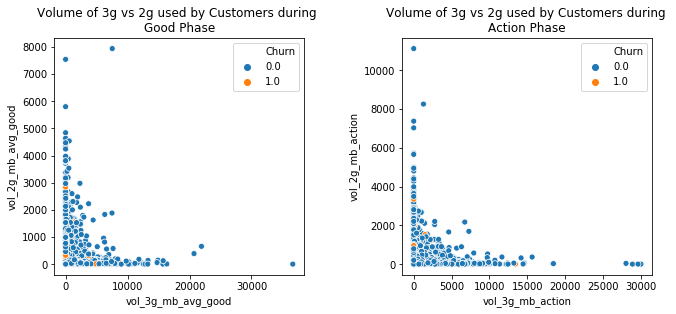

In [40]:
fig = plt.figure(figsize = (10,5))

# good phase
plt.subplot(1,2,1)
sns.scatterplot(x = 'vol_3g_mb_avg_good', y = 'vol_2g_mb_avg_good', hue = 'Churn', data = df_hvc_final, color = 'g')
plt.title('Volume of 3g vs 2g used by Customers during \nGood Phase')

# action phase
plt.subplot(1,2,2)
sns.scatterplot(x = 'vol_3g_mb_action', y = 'vol_2g_mb_action', hue = 'Churn', data = df_hvc_final, color = 'y')
plt.title('Volume of 3g vs 2g used by Customers during \nAction Phase')
fig.tight_layout(pad = 3.0)

# More number of customers use both 2g and 3g data. But the max. volume used by customers on 3g 
# network is ~3 times more than that of 2g users. This is obvious since 3g is faster and hence
# user can utilize more data.
# Also there is not much of a difference in data Volume consumed across 2g/3g across both phases.

### Cap outliers in all numeric variables with k-sigma technique

Before performing PCA, we must ensure that there are no significant outliers in our data, otherwise PCA results won't be reliable.

In [41]:
# instead of dropping the outliers and losing information we will cap them at 3 times the std devation of the column mean to reduce their influence while scaling
def cap_outliers(array):
    # here k=3
    upper_limit = array.mean() + 3 * array.std()
    lower_limit = array.mean() - 3 * array.std()
    array[array > upper_limit] = upper_limit
    array[array < lower_limit] = lower_limit   
    return array

In [42]:
# capping the outliers in the numeric columns
df_hvc_final[df_hvc_final.select_dtypes([np.number]).columns] = df_hvc_final[df_hvc_final.select_dtypes([np.number]).columns].apply(cap_outliers, axis=0)

In [43]:
df_hvc_final.describe(percentiles=[0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.80, 0.90, 0.95, 0.96, 0.97, 
                              0.98, 0.99, 0.995])

# Observe in the table below, there are no outliers left in the data.

,arpu_avg_good,onnet_mou_avg_good,offnet_mou_avg_good,roam_ic_mou_avg_good,roam_og_mou_avg_good,loc_og_t2t_mou_avg_good,loc_og_t2m_mou_avg_good,loc_og_t2f_mou_avg_good,loc_og_t2c_mou_avg_good,loc_og_mou_avg_good,std_og_t2t_mou_avg_good,std_og_t2m_mou_avg_good,std_og_t2f_mou_avg_good,std_og_mou_avg_good,isd_og_mou_avg_good,spl_og_mou_avg_good,og_others_avg_good,total_og_mou_avg_good,loc_ic_t2t_mou_avg_good,loc_ic_t2m_mou_avg_good,loc_ic_t2f_mou_avg_good,loc_ic_mou_avg_good,std_ic_t2t_mou_avg_good,std_ic_t2m_mou_avg_good,std_ic_t2f_mou_avg_good,std_ic_mou_avg_good,total_ic_mou_avg_good,spl_ic_mou_avg_good,isd_ic_mou_avg_good,ic_others_avg_good,total_rech_num_avg_good,total_rech_amt_avg_good,max_rech_amt_avg_good,last_day_rch_amt_avg_good,total_rech_data_avg_good,max_rech_data_avg_good,count_rech_2g_avg_good,count_rech_3g_avg_good,av_rech_amt_data_avg_good,vol_2g_mb_avg_good,vol_3g_mb_avg_good,night_pck_user_avg_good,monthly_2g_avg_good,sachet_2g_avg_good,monthly_3g_avg_good,sachet_3g_avg_good,fb_user_avg_good,arpu_action,onnet_mou_action,offnet_mou_action,roam_ic_mou_action,roam_og_mou_action,loc_og_t2t_mou_action,loc_og_t2m_mou_action,loc_og_t2f_mou_action,loc_og_t2c_mou_action,loc_og_mou_action,std_og_t2t_mou_action,std_og_t2m_mou_action,std_og_t2f_mou_action,std_og_mou_action,isd_og_mou_action,spl_og_mou_action,og_others_action,total_og_mou_action,loc_ic_t2t_mou_action,loc_ic_t2m_mou_action,loc_ic_t2f_mou_action,loc_ic_mou_action,std_ic_t2t_mou_action,std_ic_t2m_mou_action,std_ic_t2f_mou_action,std_ic_mou_action,total_ic_mou_action,spl_ic_mou_action,isd_ic_mou_action,ic_others_action,total_rech_num_action,total_rech_amt_action,max_rech_amt_action,last_day_rch_amt_action,total_rech_data_action,max_rech_data_action,count_rech_2g_action,count_rech_3g_action,av_rech_amt_data_action,vol_2g_mb_action,vol_3g_mb_action,night_pck_user_action,monthly_2g_action,sachet_2g_action,monthly_3g_action,sachet_3g_action,fb_user_action,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,days_since_last_rech_action,days_since_last_rech_data_action
count,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000
mean,545.350618,251.462129,367.153562,12.058677,20.012068,74.769355,158.547785,5.665954,1.535067,244.981608,157.535951,172.025602,1.329604,344.927915,1.331197,5.978853,0.321481,604.446752,59.513125,146.436790,13.948431,224.038259,12.507641,26.291320,2.195740,42.266416,281.983080,0.038551,8.524421,0.989018,11.562418,649.614802,165.232931,96.394834,1.680999,76.691626,1.244021,0.395446,130.064658,113.995104,326.440732,-0.423515,0.171752,1.062066,0.203715,0.172973,0.084297,498.441171,219.165192,329.757870,11.840082,21.422889,68.802292,150.181473,5.303427,1.523809,228.274583,133.629622,146.690750,1.156614,295.873684,1.

In [44]:
# divide data into train and test data set
df_hvc_final['Churn']=pd.to_numeric(df_hvc_final['Churn'])
X = df_hvc_final.drop("Churn", axis = 1)
y = df_hvc_final.Churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100, stratify = y) #stratified to ensure class balance in test and train split

print(X_train.shape)
print(X_test.shape)

(21000, 101)
(9001, 101)


## Model Building

#### PCA

In [45]:
# apply pca to train data for dimensionality reduction
# Creating a pipeline to apply Standardization and PCA
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

In [46]:
pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)

In [47]:
# extract pca model from pipeline
pca = pca.named_steps['pca']

# look at explained variance of PCA components
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))


# Here notice 2 things, the highest initial Principal components explain a large amount of 
# variance but as we go down the line, the variance explained with additional PC decreases. 
# 38 PC explain 90% of variance, 49 explain 95% of the variance

0       14.24
1       25.72
2       32.71
3       39.16
4       43.51
5       46.69
6       49.64
7       52.40
8       54.96
9       57.36
10      59.63
11      61.58
12      63.49
13      65.27
14      66.94
15      68.55
16      70.15
17      71.67
18      73.09
19      74.40
20      75.59
21      76.67
22      77.71
23      78.70
24      79.65
25      80.58
26      81.48
27      82.37
28      83.22
29      84.06
30      84.87
31      85.66
32      86.43
33      87.18
34      87.90
35      88.56
36      89.20
37      89.77
38      90.33
39      90.86
40      91.37
41      91.87
42      92.36
43      92.84
44      93.24
45      93.64
46      94.00
47      94.35
48      94.70
49      95.03
50      95.33
51      95.61
52      95.89
53      96.15
54      96.39
55      96.62
56      96.86
57      97.08
58      97.31
59      97.52
60      97.73
61      97.94
62      98.13
63      98.31
64      98.49
65      98.64
66      98.79
67      98.92
68      99.02
69      99.12
70      99.21
71    

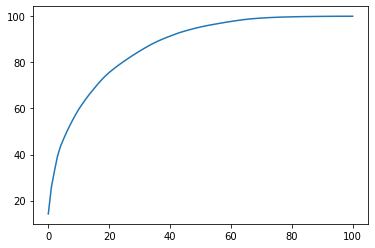

In [48]:
# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=2)
plt.plot(cumulative_variance)

#### Custom error metrics

In [49]:
# sensitivity = TP/(TP+FN), given our objective is to identify the churn customers we will 
# focus on increasing the sensitivity. We are ok even if a few non churners are predicted wrong.
# But churner prediction must have higher accuracy.

from sklearn.metrics import make_scorer
def sensitivity_loss(X, Y):
    sensitivity, specificity, _ = sensitivity_specificity_support(X, Y, average='binary')    
    return sensitivity

sensitivity_scorer = make_scorer(sensitivity_loss, greater_is_better=True)

***Note: Since it is more important to identify churners than the non-churners accurately, (as per our business goal) we are focusing more on Specificity while building our models, while ensuring descent Sensitivity and overall model accuracy.***
<br><br>
We shall build 3 model for our Predicitve Model Building with:<br>
- `Logistic Regression`,
- `Random Forest Classifier`,
- `XGBoost`

### Logistic Regression Model

In [50]:
# Next we will perform a grid search to find out the best hyperparameters:
# pca__n_components >> Giving the Optimum numer of Principal Components, here we choose between 
# 30 to 55 PCs accounting for 90-95% of variance
# logistic__C >> Inverse of regularization strength; must be a positive float. Like in support 
# vector machines, smaller values specify stronger regularization.
# logistic__penalty >> Used to specify the norm used in the penalization.

# create pipeline - standradization, PCA, Logistic Regression
steps_pca = [("scaler", StandardScaler()), 
         ("pca", PCA()),
         ("logistic", LogisticRegression(class_weight='balanced')) # The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
        ]

#PCA is added to the pipeline to prevent data leakage during cross validation

# compile the above pipeline
pca_logistic_reg = Pipeline(steps_pca)

# hyperparameter space
params = {'pca__n_components': list(range(30,70,2)), 
          'logistic__C': [0.01,0.1,0.2,0.3],
          'logistic__penalty': ['l1', 'l2']}

# create 5 folds of validation
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# create gridsearch object
model = GridSearchCV(estimator=pca_logistic_reg, cv=folds, param_grid=params, scoring=sensitivity_scorer, n_jobs=-1, verbose=1)


# fit model on training data
model.fit(X_train, y_train)

# print the optimum AUC score and the best hyperparameters
print("Best Sensitivity after hyperparameter tuning: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  4.1min finished


Best Sensitivity after hyperparameter tuning:  0.8361698478846187
Best hyperparameters:  {'logistic__C': 0.2, 'logistic__penalty': 'l2', 'pca__n_components': 66}


In [51]:
# predict on test data
y_pred = model.predict(X_test)

# confusion matrix
cnf_mtrx = confusion_matrix(y_test, y_pred)
print(cnf_mtrx)

# check sensitivity and specificity
# sensitivity = TP/(TP+FN)
# specificity = TN/(TN+FP)
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity =", round(sensitivity, 2))
print("Specificity =",round(specificity, 2))

# AUC
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC =", round(roc_auc_score(y_test, y_pred_prob),2))


# The sensitivity and specificity scores are quite similar indicating that both churn and 
# non-churn customers are being predicted correctly, there is no bias.
# AUC at 0.91 is very good and both training and test AUC shows similar results indicating that 
# the model has generalized well

[[7044 1225]
 [ 112  620]]
Sensitivity = 0.85
Specificity = 0.85
AUC = 0.91


### Random Forest Model

In [52]:
# Next we will perform a grid search to find out the best hyperparameters:
# max_features >> The number of features to consider when looking for the best split
# n_estimators >> The number of trees in the forest
# max_depth >> The maximum depth of the tree
# min_samples_split >> The minimum number of samples required to split an internal node
# min_samples_leaf >> The minimum number of samples required to be at a leaf node

# create pipeline - standradization, PCA, Random Forest
steps_pca_rf = [("scaler", StandardScaler()), 
         ("pca", PCA()),
         ("rf", RandomForestClassifier(class_weight='balanced')) # The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
        ]

#PCA is added to the pipeline to prevent data leakage during cross validation

# compile the above pipeline
pca_rf = Pipeline(steps_pca_rf)

# hyperparameter space
params = {'rf__max_features' : ['sqrt','log2',None],
            'rf__n_estimators': list(range(100,1000,100)),
            'rf__max_depth': list(range(3,30,3)),
            'rf__min_samples_split': list(range(10,500,20)),
            'rf__min_samples_leaf': list(range(1,100,10))}


# create 3 folds of validation to save time,ideally 5 fold should be used for stable results
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 100)

# create Random search object as Grid search on RF takes expectionally large amount of time
model_rf = RandomizedSearchCV(n_iter=50, estimator=pca_rf, cv=folds, param_distributions =params, scoring=sensitivity_scorer, n_jobs=-1, verbose=1)


# fit model on training data
model_rf.fit(X_train, y_train)

# print the optimum AUC score and the best hyperparameters
print("Best AUC after hyperparameter tuning: ", model_rf.best_score_)
print("Best hyperparameters: ", model_rf.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 108.2min finished


Best AUC after hyperparameter tuning:  0.7700253856668619
Best hyperparameters:  {'rf__n_estimators': 100, 'rf__min_samples_split': 450, 'rf__min_samples_leaf': 41, 'rf__max_features': None, 'rf__max_depth': 3}


In [53]:
# predict on test data
y_pred = model_rf.predict(X_test)

# confusion matrix
cnf_mtrx = confusion_matrix(y_test, y_pred)
print(cnf_mtrx)

# check sensitivity and specificity
# sensitivity = TP/(TP+FN)
# specificity = TN/(TN+FP)
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity =", round(sensitivity, 2))
print("Specificity =",round(specificity, 2))

# AUC
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC =", round(roc_auc_score(y_test, y_pred_prob),2))


# The sensitivity and specificity scores are a bit different; the model is able to predict 
# non-churners well but not able to do as well for churners.
# AUC at 0.91 is very good and both training and test

[[6599 1670]
 [ 180  552]]
Sensitivity = 0.75
Specificity = 0.8
AUC = 0.91


### XGBoost Model

In [54]:
# Previously we used the 'balanced' paramater to handle the class imbalance problem, but XGBOOST does not support it.
# Instead we have the scale_pos_weight parameter which is nothing but the value of total_negative_examples / total_positive_examples
# Calculating the same here

from collections import Counter

# count examples in each class
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 11.288


In [55]:
# We will perform a grid search to find out the best hyperparameters with custom error metrics 
# as senitsivity: 
# learning_rate >> Step size shrinkage used in update to prevent overfitting.
# min_child_weight >> Minimum sum of instance weight (hessian) needed in a child
# gamma >> Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be
# subsample >> Subsample ratio of the training instances
# colsample_bytree >> subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed
# max_depth >> The maximum depth of the tree


# create pipeline - standradization, PCA, XG Boost

steps_pca_xg = [("scaler", StandardScaler()), 
         ("pca", PCA()),
         ("xg", xgb.XGBClassifier(scale_pos_weight=estimate)) # The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
        ]

#PCA is added to the pipeline to prevent data leakage during cross validation

# compile the above pipeline
pca_xg = Pipeline(steps_pca_xg)

# hyperparameter space
params = {'xg__learning_rate': [0.01,0.03,0.05,0.07,0.09,0.1,0.2,0.3,0.4,0.5], #Range doesnot support floating point values
        'xg__min_child_weight': list(range(1, 50, 4)),
        'xg__gamma': [0.3,0.5,0.7,0.9,1,1.2,1.5],
        'xg__subsample': [0.3,0.5,0.6,0.8,0.9,1.2,1.3,1.5,2,2.3,5],
        'xg__colsample_bytree': [0.3,0.5,0.6,0.8,0.9,1.2,1.3,1.5,1.7,2],
        'xg__max_depth': list(range(3, 15,3))
        }

# create 3 folds of validation, we are using 3 to save some time ideally 5 fold should be used for stability of results
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 100)

# create Random search object as Grid search on XGB takes long time
model_xg = RandomizedSearchCV(n_iter=500, estimator=pca_xg, cv=folds, param_distributions =params, scoring=sensitivity_scorer, n_jobs=-1, verbose=1)


# fit model on training data
model_xg.fit(X_train, y_train)

# print the optimum AUC score and the best hyperparameters
print("Best Sensitivity after hyperparameter tuning: ", model_xg.best_score_)
print("Best hyperparameters: ", model_xg.best_params_)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 26.1min finished


Best Sensitivity after hyperparameter tuning:  0.7987091337012714
Best hyperparameters:  {'xg__subsample': 0.5, 'xg__min_child_weight': 37, 'xg__max_depth': 3, 'xg__learning_rate': 0.07, 'xg__gamma': 1.5, 'xg__colsample_bytree': 0.9}


In [56]:
# predict on test data
y_pred = model_xg.predict(X_test)

# confusion matrix
cnf_mtrx = confusion_matrix(y_test, y_pred)
print(cnf_mtrx)

# check sensitivity and specificity
# sensitivity = TP/(TP+FN)
# specificity = TN/(TN+FP)
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity =", round(sensitivity, 2))
print("Specificity =",round(specificity, 2))

# AUC
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC =", round(roc_auc_score(y_test, y_pred_prob),2))


# The sensitivity and specificity scores are different, the sensitivity score is lower than that 
# of Logistic Regression but better than RF. AUC at 0.91 is very good and both training and test.
# Logistic regression is still giving the best results.

[[7234 1035]
 [ 153  579]]
Sensitivity = 0.79
Specificity = 0.87
AUC = 0.91


#### Predictive Model Building Observations:
<br>
1. The `Logistic Regression Model` provides a more balanced result on both Sensitivity and Specificity.
<br><br>
2. The `XGBoost Model` provides the best Specificity results, with slighlty less Sensitivity.
<br><br>
3. The `Random Forest Model` provides a good Specificity, but a t the expense of a slightly low Sensitivity.
<br><br>
4. AUC, i.e., (Sensitivity/(1-Specificity)) is quite good at `0.91` for each of the three models, with good specificity and descent sensitivity, and accuracy. Thus all our models works pretty well while Classifying the minority class `Churn`!
<br><br>
Since we are are looking for a model that does well classifying our minority class 'Churn', while still performing good overall, we choose the `Logistic Regression Model` as our final model for making Churn predictions.

_______________________________________________________________________________________________________

## Feature Selection
### Determing the driving factors towards Customer Churn
<br>
We shall perform feature selection with Random Forest Classification, to determine the driving factors contributing to churn, and then derive the major customer churning factors out of it.

### Random Forest Model

In [57]:
X_train.head()

,arpu_avg_good,onnet_mou_avg_good,offnet_mou_avg_good,roam_ic_mou_avg_good,roam_og_mou_avg_good,loc_og_t2t_mou_avg_good,loc_og_t2m_mou_avg_good,loc_og_t2f_mou_avg_good,loc_og_t2c_mou_avg_good,loc_og_mou_avg_good,std_og_t2t_mou_avg_good,std_og_t2m_mou_avg_good,std_og_t2f_mou_avg_good,std_og_mou_avg_good,isd_og_mou_avg_good,spl_og_mou_avg_good,og_others_avg_good,total_og_mou_avg_good,loc_ic_t2t_mou_avg_good,loc_ic_t2m_mou_avg_good,loc_ic_t2f_mou_avg_good,loc_ic_mou_avg_good,std_ic_t2t_mou_avg_good,std_ic_t2m_mou_avg_good,std_ic_t2f_mou_avg_good,std_ic_mou_avg_good,total_ic_mou_avg_good,spl_ic_mou_avg_good,isd_ic_mou_avg_good,ic_others_avg_good,total_rech_num_avg_good,total_rech_amt_avg_good,max_rech_amt_avg_good,last_day_rch_amt_avg_good,total_rech_data_avg_good,max_rech_data_avg_good,count_rech_2g_avg_good,count_rech_3g_avg_good,av_rech_amt_data_avg_good,vol_2g_mb_avg_good,vol_3g_mb_avg_good,night_pck_user_avg_good,monthly_2g_avg_good,sachet_2g_avg_good,monthly_3g_avg_good,sachet_3g_avg_good,fb_user_avg_good,arpu_action,onnet_mou_action,offnet_mou_action,roam_ic_mou_action,roam_og_mou_action,loc_og_t2t_mou_action,loc_og_t2m_mou_action,loc_og_t2f_mou_action,loc_og_t2c_mou_action,loc_og_mou_action,std_og_t2t_mou_action,std_og_t2m_mou_action,std_og_t2f_mou_action,std_og_mou_action,isd_og_mou_action,spl_og_mou_action,og_others_action,total_og_mou_action,loc_ic_t2t_mou_action,loc_ic_t2m_mou_action,loc_ic_t2f_mou_action,loc_ic_mou_action,std_ic_t2t_mou_action,std_ic_t2m_mou_action,std_ic_t2f_mou_action,std_ic_mou_action,total_ic_mou_action,spl_ic_mou_action,isd_ic_mou_action,ic_others_action,total_rech_num_action,total_rech_amt_action,max_rech_amt_action,last_day_rch_amt_action,total_rech_data_action,max_rech_data_action,count_rech_2g_action,count_rech_3g_action,av_rech_amt_data_action,vol_2g_mb_action,vol_3g_mb_action,night_pck_user_action,monthly_2g_action,sachet_2g_action,monthly_3g_action,sachet_3g_action,fb_user_action,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,days_since_last_rech_action,days_since_last_rech_data_action
81898,235.4320,2.060,82.410,0.00,0.000,2.060,76.055,3.615,2.180,81.735,0.000,0.000,0.555000,0.555,0.000,2.180,0.000,84.475,4.55,199.035,32.545,236.145,0.000,0.505,7.010,7.520,243.665,0.0,0.000,0.00,6.5,292.0,152.0,50.0,2.0,152.0,1.0,1.0,304.0,58.370,524.555,0.0,0.0,1.0,0.0,1.0,1.0,393.619,3.63,115.46,0.00,0.00,3.63,107.13,4.51,0.0,115.28,0.00,1.13,2.68,3.81,0.0,0.00,0.0,119.09,11.04,461.88,49.14,522.08,0.00,39.99,14.28,54.28,576.36,0.00,0.0,0.00,6.0,484.0,152.0,152.0,4.0,152.0,2.0,2.0,608.0,97.89,631.48,0.0,0.0,2.0,0.0,2.0,1.0,2860.0,492.59,625.33,486.54,0.0,0.0,0.0
33489,342.9335,197.895,93.030,26.08,22.895,23.065,24.250,0.675,6.180,48.000,165.645,46.805,0.000000,212.450,0.000,11.860,0.000,272.330,28.66,21.420,0.965,51.050,4.200,1.610,0.000,5.820,57.310,0.2,0.000,0.23,9.5,431.5,119.0,88.5,2.5,40.5,2.0,0.5,78.0,234.425,0.000,0.0,0.0,2.0,0.0,0.5,1.0,285.105,144.29,134.38,0.00,0.00,83.24,70.38,2.03,0.0,155.66,61.04,61.96,0.00,123.01,0.0,1.19,0.0,279.88,18.59,39.46,12.31,70.38,2.38,3.34,0.00,5.73,76.44,0.25,0.0,0.08,6.0,307.0,130.0,67.0,1.0,23.0,1.0,0.0,23.0,2.54,0.00,0.0,0.0,1.0,0.0,0.0,1.0,440.0,0.00,0.00,0.00,0.0,2.0,5.0
21296,703.6395,311.785,445.285,0.00,0.000,297.090,391.685,19.145,0.000,707.935,14.685,32.750,1.040000,48.485,3.565,0.250,0.000,760.245,221.93,486.250,27.845,736.035,32.985,48.135,2.990,84.115,830.655,0.0,10.485,0.00,6.5,885.0,339.0,169.5,0.0,0.0,0.0,0.0,0.0,0.000,0.000,-1.0,0.0,0.0,0.0,0.0,-1.0,668.214,302.56,554.08,0.00,0.00,300.98,473.18,13.81,0.0,787.98,1.58,67.08,0.00,68.66,0.0,0.00,0.0,856.64,197.71,397.26,10.54,605.53,0.00,45.24,0.00,45.24,651.86,0.00,0.0,1.08,7.0,925.0,479.0,479.0,2.0,179.0,1.0,1.0,202.0,888.75,279.66,0.0,0.0,1.0,1.0,0.0,1.0,1166.0,359.82,1110.21,551.99,0.0,3.0,12.0
85765,549.9085,69.635,889.955,0.00,0.000,69.395,245.220,0.000,0.000,314.615,0.240,593.085,36.429878,644.970,0.000,0.000,0.000,959.595,43.89,195.190,0.655,239.750,3.960,120.190,4.425,128.595,368.400,0.0,0.

In [58]:
rf_model = RandomForestClassifier(n_estimators=100, max_features="auto", class_weight="balanced", oob_score=True, random_state=100, verbose=1)

rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=100, verbose=1,
                       warm_start=False)

In [59]:
# Next we will perform a grid search to find out the best hyperparameters:

# create pipeline - standradization, PCA, Random Forest
steps_rf = [("scaler", StandardScaler()),
         ("rf", RandomForestClassifier(class_weight='balanced')) # The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data
        ]

#PCA is added to the pipeline to prevent data leakage during cross validation

# compile the above pipeline
rf = Pipeline(steps_rf)

# hyperparameter space
params = {'rf__max_features' : ['sqrt','log2',None], #none = using all features
            'rf__n_estimators': list(range(100,500,100)),
            'rf__max_depth': list(range(3,30,3)),
            'rf__min_samples_split': list(range(10,500,20)),
            'rf__min_samples_leaf': list(range(1,100,10))}

# create 3 folds of validation to save time,ideally 5 fold should be used for stable results
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 100)

# create Random search object as Grid search on RF takes expectionally large amount of time
model_rf = RandomizedSearchCV(n_iter=20, estimator=rf, cv=folds, param_distributions =params, scoring=sensitivity_scorer, n_jobs=-1, verbose=1)


# fit model on training data
model_rf.fit(X_train, y_train)

# print the optimum AUC score and the best hyperparameters
print("Best AUC after hyperparameter tuning: ", model_rf.best_score_)
print("Best hyperparameters: ", model_rf.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.8min finished


Best AUC after hyperparameter tuning:  0.8349911098777993
Best hyperparameters:  {'rf__n_estimators': 100, 'rf__min_samples_split': 370, 'rf__min_samples_leaf': 41, 'rf__max_features': None, 'rf__max_depth': 24}


In [60]:
# predict on test data
y_pred = model_rf.predict(X_test)

# confusion matrix
cnf_mtrx = confusion_matrix(y_test, y_pred)
print(cnf_mtrx)

# check sensitivity and specificity
# sensitivity = TP/(TP+FN)
# specificity = TN/(TN+FP)
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity =", round(sensitivity, 2))
print("Specificity =",round(specificity, 2))

# AUC
y_pred_prob = model_rf.predict_proba(X_test)[:, 1]
print("AUC =", round(roc_auc_score(y_test, y_pred_prob),2))


# Sensitivity scores are similar to that of Logistic with PCA, specificity and AUC are slightly 
# better than Logistic with PCA.
# But one catch is that this score was obtained with 'rf__max_features'=  None; 
# i.e rf__max_features = all features.
# However that is ok in this case as we will just be using this model to choose the top few features.

[[7400  869]
 [ 117  615]]
Sensitivity = 0.84
Specificity = 0.89
AUC = 0.94


We are getting quite good results on this non-PCA RF model. A good Specificity, with a descent Sensitivity, and a great AUC.

We shall now find out the most important features from our RF model, that help in determining the driving factors towards Customer Churn.

In [61]:
# Getting the features with their importance after training the model

features = X_train.columns
importance = model_rf.best_estimator_.named_steps['rf'].feature_importances_
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance*100})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# sort features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)

feature_importance.head(20)

,variables,importance_percentage
0,total_ic_mou_action,51.564059
1,roam_og_mou_action,8.334348
2,days_since_last_rech_action,7.840432
3,av_rech_amt_data_action,7.258262
4,last_day_rch_amt_action,4.743929
5,roam_ic_mou_action,2.364612
6,max_rech_data_action,1.803593
7,std_og_mou_avg_good,1.430714
8,days_since_last_rech_data_action,1.426231
9,loc_ic_mou_action,1.286022


Text(0.5, 1.0, 'Important Features responsible for determining \nCustomer-Churn')

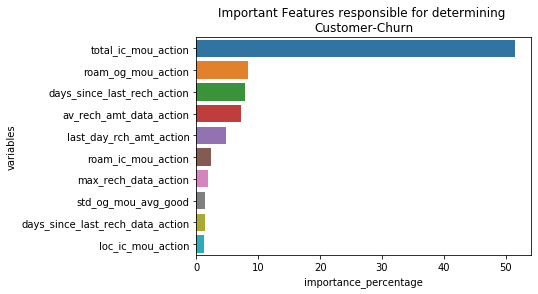

In [62]:
# plotting top 10 important features from above table.
sns.barplot(y = 'variables', x = 'importance_percentage', data = feature_importance.head(10))
plt.title('Important Features responsible for determining \nCustomer-Churn')

Text(0.5, 1, 'Churn affected by Total Incoming minutes of call during \nAction Phase')

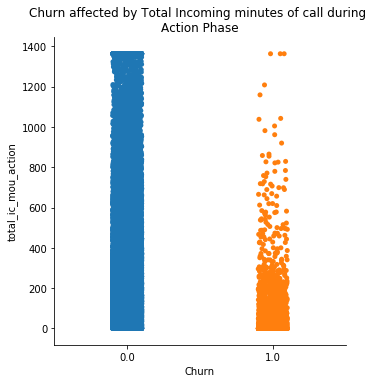

In [63]:
# lets check the `total_ic_mou_action` across churn/non-churn
sns.catplot(x = 'Churn', y = 'total_ic_mou_action', data = df_hvc_final)
plt.title('Churn affected by Total Incoming minutes of call during \nAction Phase')

# From plot -> lesser the total incoming minutes of usage (call) during action phase, more are 
# the chances of the customer churning out

Text(0.5, 1, 'Churn affected by Outgoing call Roaming minutes during\nAction Phase')

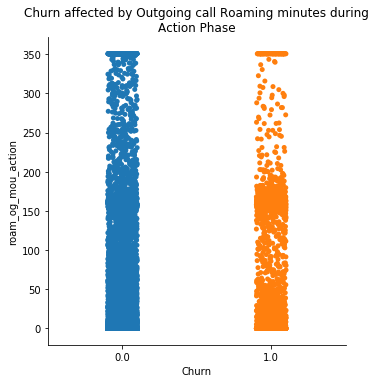

In [64]:
# lets check the `roam_og_mou_action` across churn/non-churn
sns.catplot(x = 'Churn', y = 'roam_og_mou_action', data = df_hvc_final)
plt.title('Churn affected by Outgoing call Roaming minutes during\nAction Phase')

# From plot -> decrease in outgoing call minutes while roaming during action phase, can indicate
# that the customer could churn.

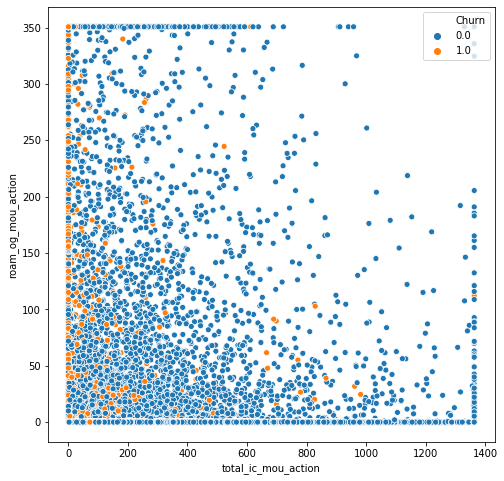

In [65]:
plt.figure(figsize = (8,8))
sns.scatterplot(x = 'total_ic_mou_action', y = 'roam_og_mou_action', hue = 'Churn', data = df_hvc_final)

# Notice most of the churned customers are those who have high og roaming call mou requirement.
# Also observe that the customers who have high outgoing roaming mou have usually less total 
# incoming mou. Since this dataset is from 2014, and back at that time, incoming calls while roaming
# were also chargeable (especially in indian market), so guess is that people used to avoid mou 
# on incoming calls while being outside the home network.

#### Observations:

- ***total_ic_mou_action*** is the best indicator of churn. Lesser its value, more the chances of churn.
- ***roam_og_mou_action*** is also a strong driving factor towards customer churn. Lesser the Roaming Outgoing mou during action phase, more the chances of customer churn.
- ***days_since_last_rech*** : more the number of days since last recharge, higher the chances of customer churning.
- ***av_rech_amt_data_action*** : lesser the avg amount of data recharge by the customer in the action phase, more are the chances of churning.

## Recommendations:

From the top 5 factors seen in the above plot we can derive the following trends-
<br><br>
1. **Total Incoming Minutes of usage** in the action phase is by far the most critical indicator of churn. Once a customer stops or reduces mou on incoming calls, this should ring a bell. Company should pay special attention to this, and monitor this. It can be try to attract customers by providing special offers.
<br><br>
2. Company should also pay heed to the **roaming** charges incurred by the user, or possibly poor network service for customer mobility related scenarios when outside home network.
<br><br>
3. If a user is not **recharging** for some time both on data and package, then he is more likely to churn, and hence company could send him offers or vouchers, to get him back to using their network and decrease his churning chances.
<br><br>
4. Most of the features driving to churn as per our model analysis, are based on minutes of usage on call for a customer (inc/outg). For this company can maintain logs to track the mou spent by customer on calls over months, and accordingly interact with customers to check if they have any grievances, attract them with offers, data packs, etc. to keep them churning away from competition.
<br><br>
5. Although not part of data provided, still a strong recommendation to the company would be to check on the competition's schemes/plans, which might attract its customers anytime, and try to provide better service across competition.